In [145]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot
import awkward as ak
from fast_histogram import histogram2d
import seaborn as sn
from sklearn.preprocessing import normalize

In [146]:
MIN_RES = 20
RESOLUTION = int(5*MIN_RES)
N_events = 1000 #events to load
MAX_EVENTS = 100 #images to make
savepath = "/home/agrefsru/imcalML/fig/"
path = "/disk/atlas3/data_MC/delphes/black_holes_1000events.root:Delphes"
data_paths = ["/disk/atlas3/data_MC/delphes/black_holes_1000events.root:Delphes", 
            "/disk/atlas3/data_MC/delphes/ttbar_13TeV_pTmin1000_1000events.root:Delphes",
            "/disk/atlas3/data_MC/delphes/sphalerons.root:Delphes"]

In [147]:
def cal_image_plot(ax):
    """
    Formating of calorimeter image
    """
    ax.set_ylabel(r"$\phi$ [radians]]", fontsize=16)
    ax.set_xlabel(r"$\eta$", fontsize=16)
    #ax.set_title("Calorimeter image", fontsize=20, color="black")
    ax.tick_params(which="both", direction="inout", top=True, right=True, labelsize=14, pad=15, length=4, width=2)
    ax.tick_params(which="major", length=8)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()

def create_histograms(x, y, z):
    max_available_events = len(x)
    if max_available_events < MAX_EVENTS:
        max_events = max_available_events
    else: max_events = MAX_EVENTS
    Cal = [histogram2d(x[i], y[i], 
            range=[[-np.pi, np.pi], [-2.5, 2.5]], bins=RESOLUTION, 
            weights=z[i]) 
            for i in range(0, max_events)]
    return Cal

def preproc_histograms(hists:list):
    hists = [item/np.amax(item) for item in hists]
    return hists

def filters(key:str, image):
    if key=="saturate":
        image[np.nonzero(image)] = 255
        image = image.astype(int)
        print(np.max(image))
    return image

In [148]:
#Open file in with-function will close it when you exit
def load_data(rootfile:str, branch:str, keys:list):
    with uproot.open(rootfile) as file:
        valid_list = [key in file.keys() for key in keys]
        if valid_list:
            arr = file[branch].arrays(keys, library="ak", how="zip")[0:N_events]
            return arr[branch]
        else:
            print(keys[not(valid_list)], " not present in data.")


clusters = [load_data(path, "Tower", 
                        ["Tower.ET", "Tower.Eta", "Tower.Phi", "Tower.Eem", "Tower.Ehad", "Tower.E"])
                        for path in data_paths]
tracks = [load_data(path, "Track", 
                        ["Track.PT", "Track.Eta", "Track.Phi"])
                        for path in data_paths]


In [149]:
#Pad Tower data and normalise
max_hits = np.max([np.max([len(event) for event in item["Eta"]]) for item in clusters])
print(max_hits)
clusters = [ak.pad_none(item, max_hits, axis=-1) for item in clusters]

#normalise and remove None
for i in range(len(clusters)):
    ak.fill_none(clusters[i], 0)
    clusters[i].Eem_norm = clusters[i].Eem/ak.max(clusters[i].Eem, axis=1)
    clusters[i].Ehad_norm = clusters[i].Ehad/ak.max(clusters[i].Ehad, axis=1)
    clusters[i].ET_norm = clusters[i].ET/ak.max(clusters[i].ET, axis=1)


705


In [150]:
#Pad track data and normalise
max_hits = np.max([np.max([len(event) for event in item["Eta"]]) for item in tracks])
print(max_hits)
tracks = [ak.pad_none(item, max_hits, axis=-1) for item in tracks]

#normalise
for i in range(len(tracks)):
    ak.fill_none(tracks[i], 0)
    tracks[i].PT_norm = tracks[i].PT/ak.max(tracks[i].PT, axis=1)

380


In [151]:
hists_Eem = create_histograms(ak.to_numpy(clusters[0].Phi), ak.to_numpy(clusters[0].Eta), ak.to_numpy(clusters[0].Eem_norm))
hists_Ehad = create_histograms(ak.to_numpy(clusters[0].Phi), ak.to_numpy(clusters[0].Eta), ak.to_numpy(clusters[0].Ehad_norm))
hists_tracks = create_histograms(ak.to_numpy(tracks[0].Phi), ak.to_numpy(tracks[0].Eta), ak.to_numpy(tracks[0].PT))
#normalise
hists_Eem = preproc_histograms(hists_Eem)
hists_Ehad = preproc_histograms(hists_Ehad)
hists_tracks = preproc_histograms(hists_tracks)

(100, 100, 100, 3)
255


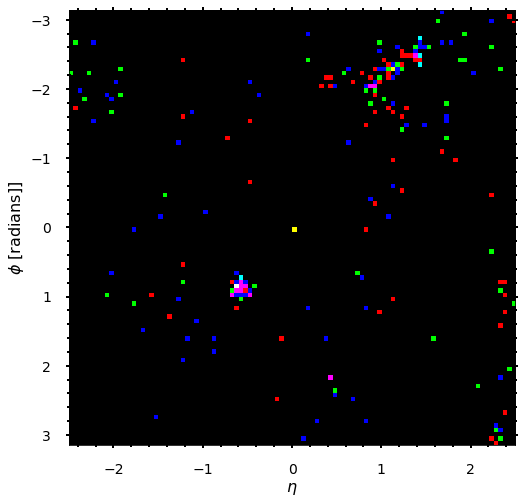

In [156]:
k = np.random.randint(0, high=len(hists_Eem)) #a random image
images = np.stack((hists_Eem, hists_Ehad, hists_tracks), axis=-1)
print(images.shape)
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
cal_image_plot(axs)
image = images[k]
image = filters("saturate", image)
axs.imshow(image, extent=[-2.5, 2.5, np.pi, -np.pi], aspect='auto')
